In [1]:
pip install astroNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
innvestigate 1.0.9 requires keras==2.2.4, but you have keras 3.3.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [6]:
# import imp
from astroNN.datasets import load_galaxy10
from tensorflow.keras import utils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch, time
from tqdm import tqdm


from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchmetrics.classification import Accuracy
import torch.optim as optim

import torchvision.models as models
# from torchsummary import summary
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image

In [7]:
# define device for Torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [8]:
images, labels = load_galaxy10()
images

/Users/tramle/.astroNN/datasets/Galaxy10_DECals.h5 was found!


array([[[[ 68,  19,  23],
         [ 58,  17,  33],
         [ 40,  16,  40],
         ...,
         [ 51,  46,  43],
         [ 40,  41,  33],
         [ 28,  38,  30]],

        [[ 61,  40,  37],
         [ 52,  43,  44],
         [ 29,  39,  41],
         ...,
         [ 28,  30,  42],
         [ 28,  32,  35],
         [ 33,  40,  33]],

        [[ 30,  31,  25],
         [ 24,  41,  33],
         [ 15,  45,  33],
         ...,
         [ 21,  35,  48],
         [ 25,  35,  45],
         [ 37,  41,  40]],

        ...,

        [[ 28,  32,  35],
         [ 27,  31,  32],
         [ 42,  44,  43],
         ...,
         [ 20,  37,  27],
         [ 19,  40,  21],
         [ 27,  50,  24]],

        [[ 22,  36,  37],
         [ 19,  29,  30],
         [ 33,  37,  38],
         ...,
         [ 17,  35,  35],
         [ 17,  35,  21],
         [ 26,  45,  17]],

        [[ 18,  39,  40],
         [ 14,  28,  29],
         [ 24,  30,  30],
         ...,
         [ 20,  35,  56],
        

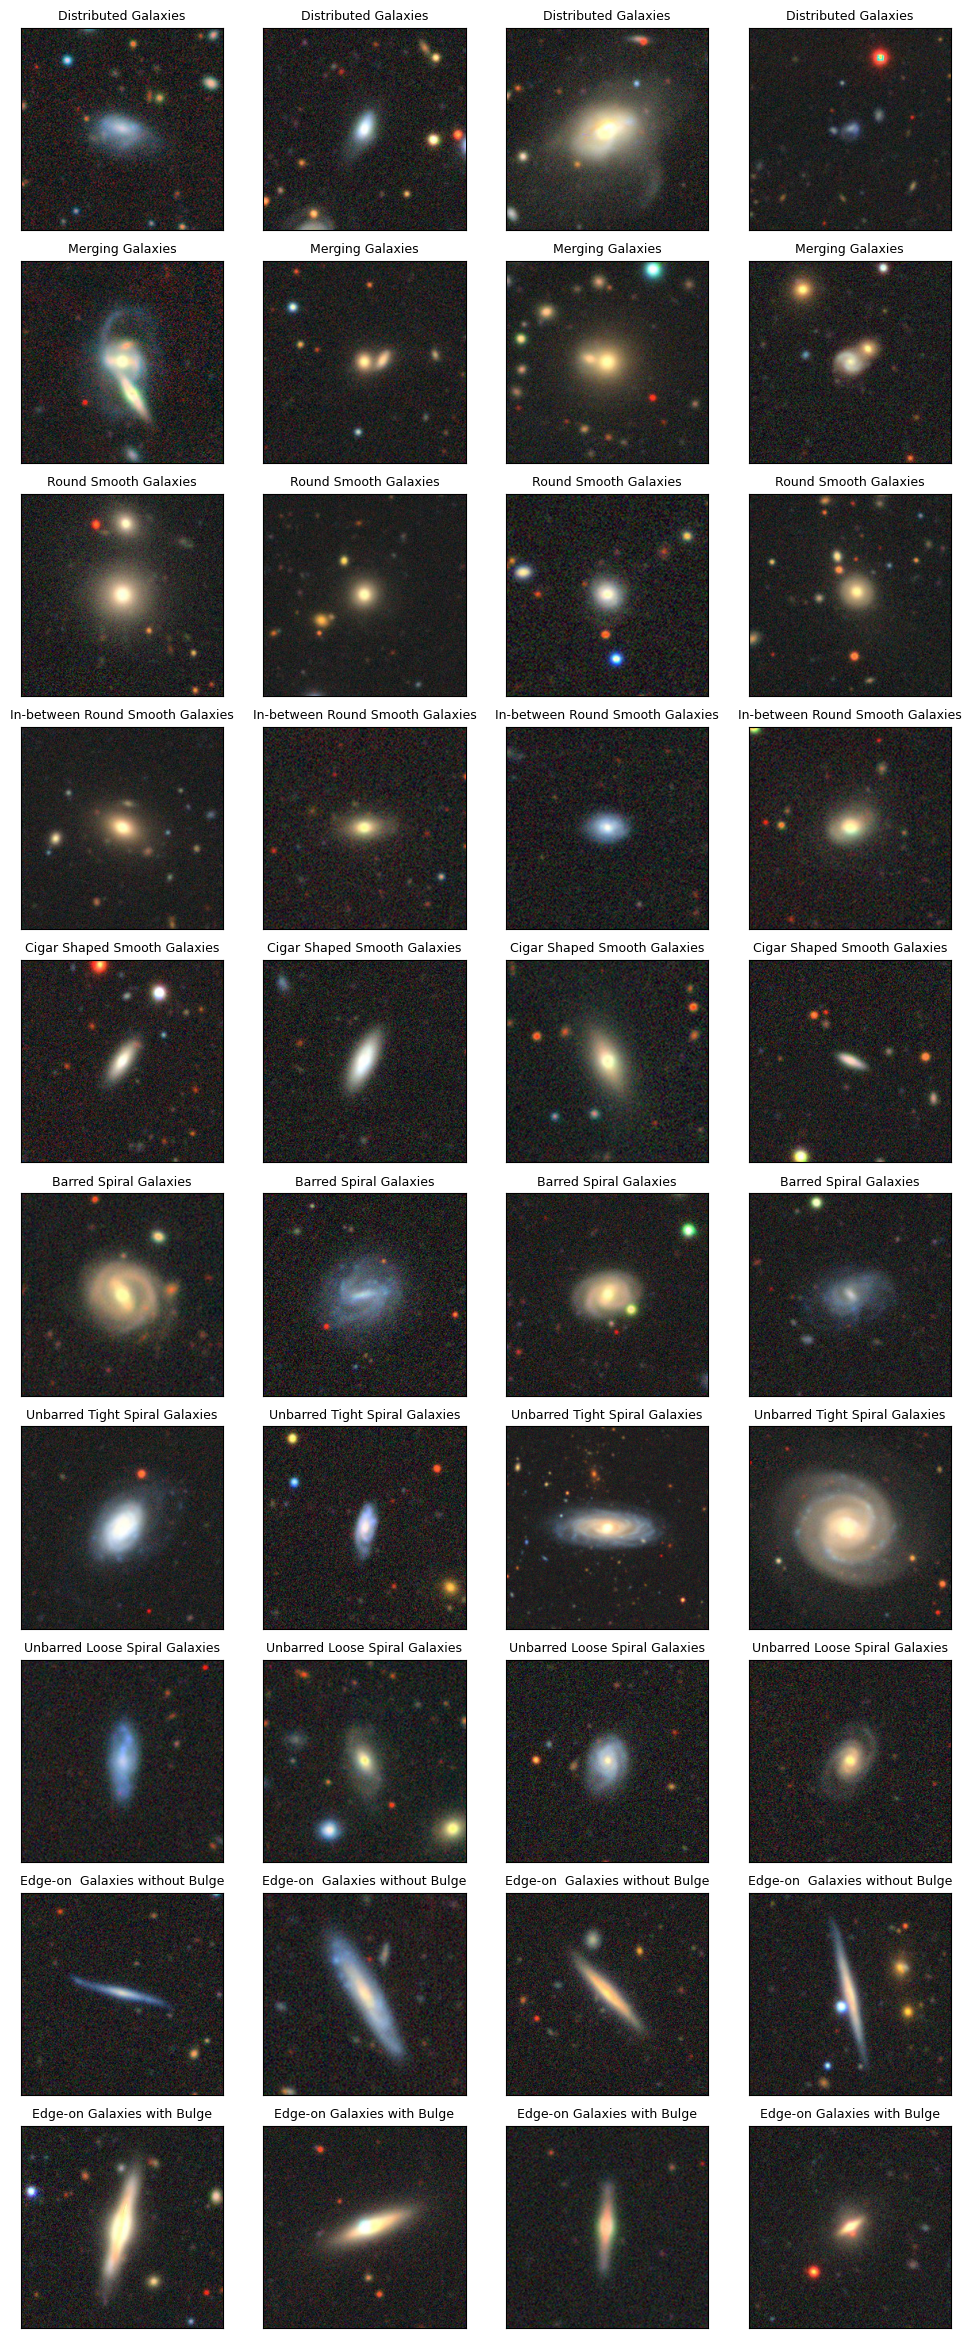

In [15]:
features = {
    0: "Distributed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on  Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

num_img = 4
fig_w = num_img * 3
fig_h = len(features) * 3
fig, axes = plt.subplots(len(features), num_img, figsize=(fig_w, fig_h))


for i, label in enumerate(features):
    # idx of images with the current label then random choose img from that idx
    img = np.where(labels == label)[0]
    rand_img = np.random.choice(img, num_img)
    # randomly select img in each label
    for j, index in enumerate(rand_img):
        ax = axes[i, j]
        image = images[index]
        ax.imshow(image, aspect='equal')
        ax.set_title(features[label], fontsize=9)
        ax.set_xticks([])  # Remove x y scale bar
        ax.set_yticks([])

plt.subplots_adjust(wspace=0.2, hspace=0.1)
fig.savefig('galaxy_10.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# check how many labels
unique, counts = np.unique(labels, return_counts=True)
unique

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [14]:
import plotly.express as px

galaxy = [features[label] for label in unique]
galaxy_counts = counts

# Create and display the plot
fig = px.bar(x=galaxy, y=galaxy_counts, title="Distribution of Galaxy Types",
             labels={"x": "Galaxy Type", "y": "Count"},
             color=galaxy,
             template="plotly_dark")
fig.update_layout(width=800, height=500)
fig.write_image("galaxy_distribution.png", scale=2)
fig.show()

In [ ]:
# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to float
labels = labels.astype(np.float32)

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [03:07<00:00, 14.5MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [03:15, 14.0MB/s]                            


# Processing the dataset
- Split the portion: 80 for train and 20 for test
- Build custom class to takes in images and labels and transform to be applied bc only to do augmentation of train set

- Do augmentation
- Transform and normalize the images
- https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html


In [ ]:
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.2)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((14188, 256, 256, 3), (14188, 10), (3548, 256, 256, 3), (3548, 10))

In [ ]:
class Galaxy10(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img =  img.astype(np.uint8)
            img = Image.fromarray(img)        # Ensure img is PILLOW Image cuz currently it's a numpy array
            img = self.transform(img)

        return img, label

# Tranform the data along with augmentation methods

In [ ]:
# augmentation and convert to tensor for train
transform_train = transforms.Compose([
      transforms.TrivialAugmentWide(),
       transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.Resize(224),
      transforms.ToTensor(),             # Converts np (H x W x C) to torch (C x H x W)
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))       # and norm from 0-255 to 0-1
      ])

# only convert to tensor for train
transform_test = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

train_ds = Galaxy10(train_images, train_labels, transform=transform_train)
test_ds = Galaxy10(test_images, test_labels, transform=transform_test)

print(len(train_ds))
print(len(test_ds))

14188
3548


# Utilize loader
- DataLoader to helps to speed up computation and reduce RAM usage, handling loading and batching during training



In [ ]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn', force=True) # fix the fork issue in colab

train_loader = torch.utils.data.DataLoader(train_ds,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=True)

# no shuffle on test loader
test_loader = torch.utils.data.DataLoader(test_ds,
                                         batch_size=128,
                                         shuffle=False,
                                         num_workers=0,
                                         pin_memory=True)

# Checking the number of batches in each loader
print(f"Number batches in training: {len(train_loader)}")    # 14188 / 128  = 111 batch
print(f"Number batches in test: {len(test_loader)}")
for images, labels in train_loader:
    print(f"Shape of 1st batch training (after transformations): {images.shape}")
    print(f"Shape of the (labels): {labels.shape}")  # Should 128
    break

Number batches in training: 111
Number batches in test: 28
Shape of 1st batch training (after transformations): torch.Size([128, 3, 224, 224])
Shape of the (labels): torch.Size([128, 10])


### Build Model

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.3 MB/s eta 0:00:00


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Build Model
- EfficientNet_B5 with preload weight:imageNet
- Feature extraction: clear last layer and adapt new layer that match with the dataset
- Fine tune hyperparameters

In [ ]:
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.base_model = timm.create_model('efficientnet_b5', pretrained=True, num_classes=0, global_pool='')

        # Transfer learning
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2048, 225)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(225, 10)
        # self.softmax = nn.Softmax(dim=1).  ----> Torch CrossEntropy func aleady handle this

    def forward(self, x):
        x = self.base_model(x)

        x = self.pooling(x)
        x = self.flatten(x)
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        # x = self.softmax(x)
        return x


model = EfficientNet()
model.to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

# Apply:
- GradScaler to help scaling the loss value, control the gradients range, faster training on NVIDIA GPUs with mix precision with both float16 and float32 precisions.
- The metrics: accurary to cal the number of correctly predicted results / total number of samples
- Objective funtion for loss is crossentropy because this is classification problems
- Optimizer with Adam with betas:0.9-0.999
- Add L2 regulation at 0.01

In [ ]:
from torch.cuda.amp import GradScaler, autocast
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "expandable_segments:True"

In [ ]:
top1_acc = Accuracy(task="multiclass", num_classes=10).to(device)

#Mixed Precision training
scaler = torch.cuda.amp.GradScaler()

#loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999), weight_decay=1e-2)

print("Training with Adam")

Training with Adam


### Train process

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save check point
directory_path = '/content/drive/My Drive/Model'
model_filename = "galaxy_efficientNetb5_2_model.pth"
save_path = os.path.join(directory_path, model_filename)

import os
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print("Directory created:", directory_path)
else:
    print("Directory already exists.")

print("Saving model to:", save_path)


Mounted at /content/drive
Directory already exists.
Saving model to: /content/drive/My Drive/Model/galaxy_efficientNetb5_2_model.pth


In [ ]:
top1 = []
train_time = []
test_time = []
train_acc = []
train_loss = []
val_acc = []
val_loss = []
counter = 0
epoch = 0

while counter < 15:   # Counter number of epochs of non-improvement before stopping

    # Training Phase
    model.train()
    run_train_loss = 0.0
    run_train_acc = 0.0
    train_batch_count = 0
    start_train_time = time.time()

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1} Training") as tepoch:
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                acc = (outputs.argmax(dim=1) == labels.argmax(dim=1)).float().mean()

            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Loss and accuracy tracking
            run_train_loss += loss.item()
            run_train_acc += acc.item()
            train_batch_count += 1

            tepoch.set_postfix_str(f"train loss: {run_train_loss / train_batch_count:.4f} - train acc: {run_train_acc / train_batch_count:.4f}")


    end_train_time = time.time()
    train_time.append(end_train_time - start_train_time)
    train_acc.append(run_train_acc / train_batch_count)
    train_loss.append(run_train_loss / train_batch_count)

    # Validation Phase
    model.eval()
    run_val_loss = 0.0
    run_val_acc = 0.0
    val_batch_count = 0
    val_y_true = []
    val_y_pred = []
    start_test_time = time.time()

    with torch.no_grad(), tqdm(test_loader, unit="batch", desc=f"Epoch {epoch+1} Validation") as vepoch:
        for images, labels in vepoch:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels.argmax(dim=1)).float().mean()

            # Update lists for classification report
            val_y_true.extend(labels.cpu().tolist())
            val_y_pred.extend(outputs.argmax(dim=1).cpu().tolist())

            # Loss and accuracy tracking
            run_val_loss += loss.item()
            run_val_acc += acc.item()
            val_batch_count += 1

            # Update progress bar postfix
            vepoch.set_postfix_str(f"val loss: {run_val_loss / val_batch_count:.4f} - val acc: {run_val_acc / val_batch_count:.4f}")



    end_test_time = time.time()
    test_time.append(end_test_time - start_test_time)
    val_acc.append(run_val_acc / val_batch_count)
    val_loss.append(run_val_loss / val_batch_count)

    current_val_acc = run_val_acc / val_batch_count
    top1.append(current_val_acc)

    # Trigger Early stopping condition base on acc (not loss)
    if current_val_acc >= max(top1[:-1], default=0):
        torch.save(model.state_dict(), save_path)
        # print("Model improved and saved.")
        counter = 0
    else:
        counter += 1

    if counter >= 15:
        print("\nEarly stopping triggered.")
        break

    epoch += 1

Epoch 32 Validation: 100%|██████████| 28/28 [00:09<00:00,  3.00batch/s, val loss: 0.4792 - val acc: 0.8695]


Early stopping triggered.


In [ ]:
print('Finished Training')
print("Results")
print(f"Top 1 Accuracy: {max(top1):.2f} - Train Time: {min(train_time):.0f} -Test Time: {min(test_time):.0f}\n")

Finished Training
Results
Top 1 Accuracy: 0.88 - Train Time: 67 -Test Time: 9



In [ ]:
val_y_true = [np.argmax(y, axis=None) for y in val_y_true]


In [ ]:
from sklearn.metrics import accuracy_score

overall_accuracy = accuracy_score(val_y_true, val_y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")


Overall Accuracy: 0.8695


In [ ]:
# Calculate and print classification report
print(classification_report(val_y_true, val_y_pred))

              precision    recall  f1-score   support

           0       0.71      0.52      0.60       229
           1       0.92      0.89      0.90       372
           2       0.93      0.96      0.94       546
           3       0.92      0.96      0.94       396
           4       0.68      0.88      0.77        50
           5       0.86      0.90      0.88       377
           6       0.80      0.80      0.80       356
           7       0.77      0.79      0.78       539
           8       0.95      0.93      0.94       309
           9       0.95      0.94      0.94       374

    accuracy                           0.87      3548
   macro avg       0.85      0.86      0.85      3548
weighted avg       0.87      0.87      0.87      3548



In [ ]:
import plotly.graph_objects as graph
# pio.renderers

fig = graph.Figure()
fig.add_trace(graph.Scatter(y=train_acc, mode='lines', name='Training Accuracy'))
fig.add_trace(graph.Scatter(y=val_acc, mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Training and Validation Accuracy over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Loss',
                  width=900,
                  height=400)

# fig.add_trace(go.Scatter(y=val_losses, fill='tozeroy', mode='lines', name='Validation Loss'))

fig.show()

In [ ]:
import plotly.graph_objects as graph
# pio.renderers

fig = graph.Figure()
fig.add_trace(graph.Scatter(y=train_loss, mode='lines', name='Training Loss'))
fig.add_trace(graph.Scatter(y=val_loss, mode='lines', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Loss',
                  width=900,
                  height=400)

# fig.add_trace(go.Scatter(y=train_losses, fill='tozeroy', mode='lines', name='Training Loss'))  # Fill to x-axis
# fig.add_trace(go.Scatter(y=val_losses, fill='tozeroy', mode='lines', name='Validation Loss'))

fig.show()

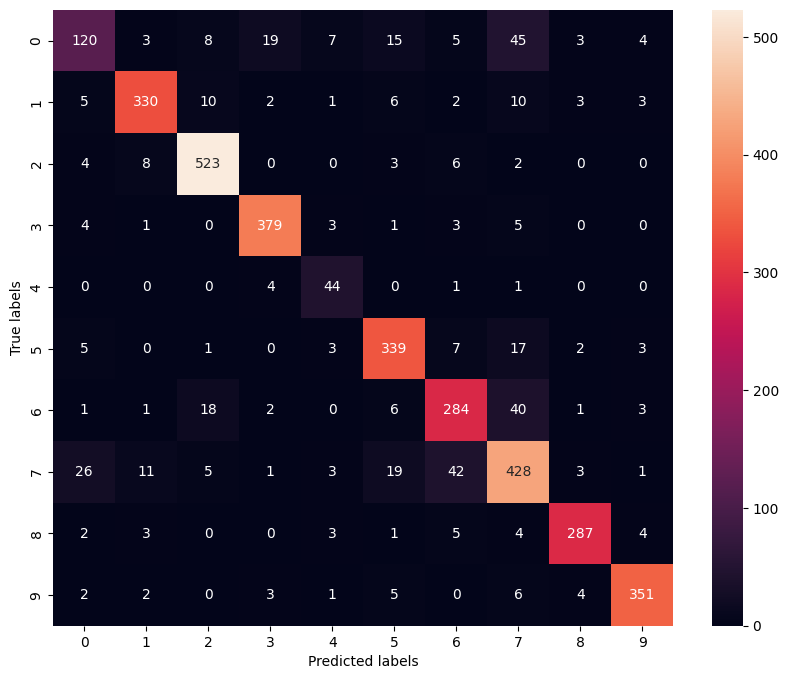

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(val_y_true, val_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()